# Project - Formandos terminados

## 1 - Imports

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sn
from matplotlib import pyplot as plt

## 2 - Read File

In [2]:
form = pd.read_excel("databases/Formandos_Terminados2018.xlsx")

In [3]:
form.shape

(124056, 63)

In [5]:
form.head(2)

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes9_Tipo,Mes10,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo
0,7206,308,D111206,Cursos de Especialização Tecnológica,M,1964-01-18,55,2,12,12 Anos,...,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
1,17170,206,D111206,Cursos de Especialização Tecnológica,F,1976-03-24,42,2,12,12 Anos,...,NaN,1,360.0,TCO,0,NaN,NaN,0,NaN,NaN


## 3 - Check nulls and variable values

In [65]:
form.isnull().sum()

UTE_ID                           0
CodCEFP                          0
CodMedidaOrcam                   0
Descritivo CodMedidaOrcam        0
Sexo                             0
                             ...  
Mes12                            0
Mes12_Remuneracao            88193
Mes12_Tipo                   88200
SomaMesesRemunerados             0
Sucessos                         0
Length: 65, dtype: int64

In [66]:
# Número de valores únicos da variável AreaFormacao
form["AreaFormacao"].nunique()

45

In [67]:
# Valores únicos da variável MotivoSaída
form['MotivoSaída'].unique()

array(['Desistente', 'Aprovado', 'Reprovado', 'Sem Classificação'],
      dtype=object)

As observações de interesse para o nosso trabalho são as que têm MotivoSaída = Aprovado. Visto que queremos utilizar para a recomendação apenas os utentes que terminaram a formação.

## 4 - Feature engeneering

In [6]:
# Criar DataFrame apenas com formandos aprovados
aprovados = form[form['MotivoSaída'] == 'Aprovado']

#### 4.1 - Criação da variável SomaMesesRemunerados

Apos selecionar os formandos com estado de conclusao «aprovado» vamos criar uma variável que permite quantificar o número de meses remunerados após o final da formação ("SomaMesesRemunerados"). 
Deste modo, é possivel criar uma variavel target com os casos em que existe remuneraçao igual ou superior a 6 meses após conclusão da intervençao (considerados casos positivos pelo IEFP).

In [7]:
aprovados["SomaMesesRemunerados"] = 0
form["SomaMesesRemunerados"] = 0

for i in range(1, 13):
    mes = i
    aprovados["SomaMesesRemunerados"] += aprovados["Mes" + str(mes)]
    form["SomaMesesRemunerados"] += form["Mes" + str(mes)]

<ipython-input-7-e57d2c68fda5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["SomaMesesRemunerados"] = 0
<ipython-input-7-e57d2c68fda5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["SomaMesesRemunerados"] += aprovados["Mes" + str(mes)]


In [8]:
# Frequencias relativas do número de meses remunerados
total = aprovados["SomaMesesRemunerados"].count()
estatistica_aprovados = aprovados["SomaMesesRemunerados"].value_counts() / total * 100

estatistica_aprovados

0     45.166152
12    15.074769
8      6.128649
9      5.805839
10     4.781628
11     3.749110
7      3.677902
6      2.877997
1      2.657251
5      2.634702
4      2.554000
2      2.448374
3      2.443627
Name: SomaMesesRemunerados, dtype: float64

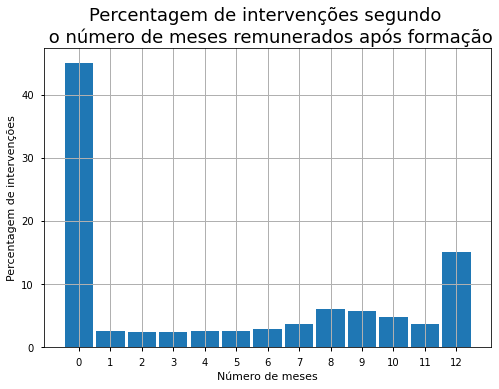

In [9]:
# Gráfico para apresentação de estatísticas
plt.style.use('seaborn-notebook')

labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] 

values = estatistica_aprovados.sort_index()

plt.bar(labels, values, width=0.9)
plt.title("Percentagem de intervenções segundo \n o número de meses remunerados após formação", size=18)
plt.xlabel("Número de meses")
plt.ylabel("Percentagem de intervenções")
plt.grid(zorder=0)

Podemos observar que cerca de 45% das intervenções não proporcionaram nenhuma remuneração aos utentes, nos 12 meses seguintes ao termino da formação. É ainda importante referir, que o segundo valor mais frequente é o 12, ou seja, maior parte dos utentes remunerados acaba por ficar empregado durante pelo menos 1 ano. 

#### 4.2 - Criação da variável Sucesso

Criação da variável binária sucesso. Um caso de sucesso corresponde a um utente que nos 12 meses após o término da formação teve pelo menos 6 meses remunerados.

In [10]:
# iniciar nova coluna Sucessos, com todos os valores a zero
form["Sucessos"] = 0
aprovados["Sucessos"] = 0

# Para as observações com mais de 6 meses de remuneração atribuir 1 à variável sucesso 
form["Sucessos"][(form["SomaMesesRemunerados"] >= 6)] = 1
aprovados["Sucessos"][(aprovados["SomaMesesRemunerados"] >= 6)] = 1
# !!!nota estamos a fazer a estatistica com valores de UTE_ID duplicados em alguns casos devido a prazos distintos

<ipython-input-10-d52a863ec067>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["Sucessos"] = 0
<ipython-input-10-d52a863ec067>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  form["Sucessos"][(form["SomaMesesRemunerados"] >= 6)] = 1
<ipython-input-10-d52a863ec067>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["Sucessos"][(aprovados["SomaMesesRemunerados"

Text(0, 0.5, 'Número de interveções')

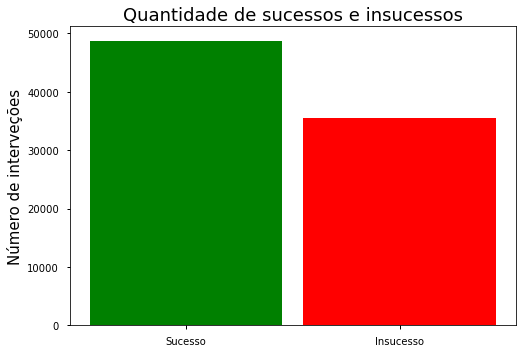

In [11]:
# Gráfico relativo ao sucesso e insucesso

outcome = ["Sucesso", "Insucesso"]

values_succ = aprovados["Sucessos"].value_counts()

plt.bar(outcome, values_succ, width=0.9, color=["green", "red"])
plt.title("Quantidade de sucessos e insucessos", size=18)
plt.ylabel("Número de interveções", size=15)

#### 4.3 - Criação da variável DuracaoFormacao

Criação de uma variável numérica que guarda a informação relativa à duração da formação (data fim - data inicio)

In [63]:
aprovados["DuracaoFormacao"] = aprovados["DataFim"] - aprovados["DataInicio"]

<ipython-input-63-083b377cb930>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["DuracaoFormacao"] = aprovados["DataFim"] - aprovados["DataInicio"]


#### 4.4 - Transformação da variavel sexo

Codificação da variável Sexo. Os valores 1's correspondem às mulheres e os 0's aos homens.

In [64]:
# transformação da variável sexo 
aprovados["Sexo"] = pd.get_dummies(aprovados.Sexo)

<ipython-input-64-d1a810bf914c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["Sexo"] = pd.get_dummies(aprovados.Sexo)


In [65]:
# verificação
aprovados.Sexo.value_counts()

0    52949
1    31311
Name: Sexo, dtype: int64

#### 4.5 - Transformação da variavel CodHabilitação

Como estamos a trabalhar com a variável CodHabilitacao que é categórica ordinal, podemos converte-la numa variável numérica. Deste modo acrescentamos informação à variável. Vamos utilizar a seguinte escala:

  - Não Sabe Ler/Escrever - 1
  - Ler/Escrever sem grau de Ensino - 2
  - 4 Anos - 4
  - 6 Anos - 6
  - 9 Anos - 9
  - 11 Anos - 11
  - 12 Anos -12
  - Pós-Secundário - 13
  - Bacharelato - 14
  - Licenciatura - 15
  - Mestrado - 17
  - Doutoramento - 20


In [66]:
# alteração dos valores da variável CodHabilitação

aprovados.loc[(aprovados.CodHabilitacao == 'NS'),'CodHabilitacao'] = 1
aprovados.loc[(aprovados.CodHabilitacao == 'SL'),'CodHabilitacao'] = 2
aprovados.loc[(aprovados.CodHabilitacao == '04'),'CodHabilitacao'] = 4
aprovados.loc[(aprovados.CodHabilitacao == '06'),'CodHabilitacao'] = 6
aprovados.loc[(aprovados.CodHabilitacao == '09'),'CodHabilitacao'] = 9
aprovados.loc[(aprovados.CodHabilitacao == '11'),'CodHabilitacao'] = 11
aprovados.loc[(aprovados.CodHabilitacao == '11'),'CodHabilitacao'] = 12
aprovados.loc[(aprovados.CodHabilitacao == 'PS'),'CodHabilitacao'] = 13
aprovados.loc[(aprovados.CodHabilitacao == 'BM'),'CodHabilitacao'] = 14
aprovados.loc[(aprovados.CodHabilitacao == 'LC'),'CodHabilitacao'] = 15
aprovados.loc[(aprovados.CodHabilitacao == 'MT'),'CodHabilitacao'] = 17
aprovados.loc[(aprovados.CodHabilitacao == 'DT'),'CodHabilitacao'] = 20

C:\Users\sarro\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [67]:
# verificação da transformação
aprovados["CodHabilitacao"].value_counts()

12    28373
9     22778
15     9702
6      9401
4      6488
11     2526
2      1959
17     1684
14      584
13      470
1       218
20       77
Name: CodHabilitacao, dtype: int64

Text(0.5, 0, 'Nº de ocurrencias')

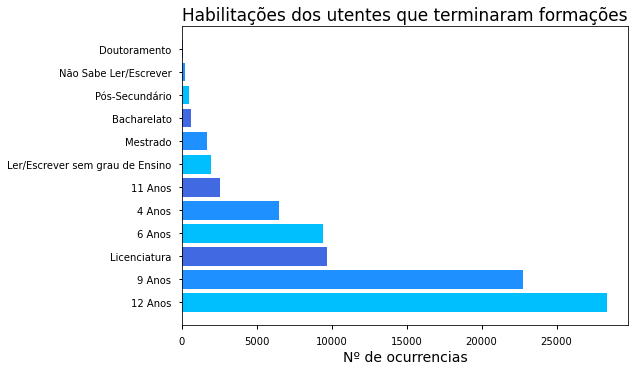

In [68]:
# Gráfico relativo ao sucesso e insucesso

freq_abs = aprovados["Habilitacao"].value_counts()

habilitações = ["12 Anos", "9 Anos", "Licenciatura", "6 Anos", "4 Anos", 
                "11 Anos", "Ler/Escrever sem grau de Ensino", "Mestrado", 
                "Bacharelato", "Pós-Secundário", "Não Sabe Ler/Escrever", "Doutoramento"]

plt.barh(habilitações, freq_abs, color=["#00BFFF", "#1E90FF", "#4169E1"])
plt.title("Habilitações dos utentes que terminaram formações", size=17)
plt.xlabel("Nº de ocurrencias", size=14)

############################ coment

#### 4.6 - Verificação dos duplicados na variável UTE_ID

In [69]:
total = aprovados['UTE_ID'].count()
total

84260

In [70]:
unicos = aprovados['UTE_ID'].nunique()
unicos

72343

In [71]:
# calcular o número de UTE_ID's repetidos
duplicados = total - unicos
print("Existem " + str(duplicados) + " UTE_ID's repetidos")

Existem 11917 UTE_ID's repetidos


In [72]:
# Verificar duas observações com o mesmo UTE_ID
form[form['UTE_ID'] == 4485606]

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo,SomaMesesRemunerados,Sucessos
571,4485606,134,D111201,Cursos de Aprendizagem - Gestão Direta,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,3,0
572,4485606,134,D111202,Cursos de Aprendizagem - Entidades Externas,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1,0


In [73]:
# ??
form.DataFim[form.UTE_ID==4485606]

571   2018-11-09
572   2018-03-20
Name: DataFim, dtype: datetime64[ns]

In [74]:
#!!! avaliar alguns dos duplicados

duplicados = form.duplicated(subset=['UTE_ID'])
teste_duplicados = form[duplicados]
teste_duplicados.head(5)

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo,SomaMesesRemunerados,Sucessos
141,1864123,315,D111206,Cursos de Especialização Tecnológica,M,1964-04-05,54,2,PS,Pós-Secundário,...,729.0,TCO,0,NaN,NaN,0,NaN,NaN,2,0
326,3432294,313,D111206,Cursos de Especialização Tecnológica,M,1986-04-02,32,2,12,12 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0
412,4065237,401,D111202,Cursos de Aprendizagem - Entidades Externas,F,1990-01-02,29,2,09,9 Anos,...,166.0,TCO,0,NaN,NaN,0,NaN,NaN,10,1
518,4379984,206,D111202,Cursos de Aprendizagem - Entidades Externas,F,1993-10-26,25,1,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0
572,4485606,134,D111202,Cursos de Aprendizagem - Entidades Externas,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1,0


## 5 - Criação do dataset final

In [75]:
aprovados.columns

Index(['UTE_ID', 'CodCEFP', 'CodMedidaOrcam', 'Descritivo CodMedidaOrcam',
       'Sexo', 'DataNascimento', 'IdadeEmAnos', 'Categoria', 'CodHabilitacao',
       'Habilitacao', 'CodFreguesia', 'Freguesia', 'CodNacionalidade',
       'DNACIONALIDADE', 'CodDeficiencia', 'Deficiente', 'DataInscricao',
       'DataInicio', 'DataFim', 'CodMotivoSaida', 'MotivoSaída', 'HorasForm',
       'AreaFormacao', 'DescAreaFormacaoEscolar', 'NivelFormacaoAccao',
       'CodSaidaProfissional', 'SaídaProfissional', 'Mes1', 'Mes1_Remuneracao',
       'Mes1_Tipo', 'Mes2', 'Mes2_Remuneracao', 'Mes2_Tipo', 'Mes3',
       'Mes3_Remuneracao', 'Mes3_Tipo', 'Mes4', 'Mes4_Remuneracao',
       'Mes4_Tipo', 'Mes5', 'Mes5_Remuneracao', 'Mes5_Tipo', 'Mes6',
       'Mes6_Remuneracao', 'Mes6_Tipo', 'Mes7', 'Mes7_Remuneracao',
       'Mes7_Tipo', 'Mes8', 'Mes8_Remuneracao', 'Mes8_Tipo', 'Mes9',
       'Mes9_Remuneracao', 'Mes9_Tipo', 'Mes10', 'Mes10_Remuneracao',
       'Mes10_Tipo', 'Mes11', 'Mes11_Remuneracao', 'Mes11_

In [76]:
final = aprovados.iloc[:, [0, 1, 4, 8, 12, 21, 22, 24, 25, 64, 65]]
final.columns

Index(['UTE_ID', 'CodCEFP', 'Sexo', 'CodHabilitacao', 'CodNacionalidade',
       'HorasForm', 'AreaFormacao', 'NivelFormacaoAccao',
       'CodSaidaProfissional', 'Sucessos', 'DuracaoFormacao'],
      dtype='object')

In [77]:
final.shape

(84260, 11)

In [78]:
final.isnull().sum()

UTE_ID                     0
CodCEFP                    0
Sexo                       0
CodHabilitacao             0
CodNacionalidade           0
HorasForm                523
AreaFormacao               0
NivelFormacaoAccao         0
CodSaidaProfissional    2686
Sucessos                   0
DuracaoFormacao            0
dtype: int64

In [79]:
final.describe()

,UTE_ID,CodCEFP,Sexo,HorasForm,AreaFormacao,Sucessos,DuracaoFormacao
count,8.426000e+04,84260.000000,84260.000000,83737.000000,84260.000000,84260.000000,84260
mean,3.814435e+06,246.212165,0.371600,209.233266,569.551851,0.420959,144 days 22:27:30.548303
std,2.115313e+06,104.918408,0.483235,293.696885,230.026076,0.493716,205 days 11:12:22.074370
min,1.070000e+02,122.000000,0.000000,0.000000,10.000000,0.000000,0 days 00:00:00
25%,1.956730e+06,134.000000,0.000000,25.000000,344.000000,0.000000,25 days 00:00:00
50%,3.832564e+06,206.000000,0.000000,100.000000,542.000000,0.000000,69 days 00:00:00
75%,6.116765e+06,312.000000,1.000000,206.000000,762.000000,1.000000,131 days 00:00:00
max,6.831598e+06,502.000000,1.000000,2302.000000,999.000000,1.000000,1082 days 00:00:00


In [59]:
final.to_csv("databases/formandos_limpo.csv")